# SAN Projekt

In the following notebook, I'm going to analyse a dataset from sociopatterns.org, a platform for "interdisciplinary research collaboration formed in 2008 that adopts a data-driven methodology to study social dynamics and human activity."[^1] Recently, they have visualized "sixty-nine days of face-to-face contact activity among more than 30'000 persons based on data collection during the INFECTIOUS: STAY AWAY exhibiton in the Science Gallery in Dublin, Ireland."[^1]
Sociopatterns.org works together with international scientists and has published ultiple peer reviewed papers. 

The data set I am going to look at studies "the contacts and friendship relations between students in a high school in Marseilles, France, in December 2013, as measured through several techniques."[^2] There are multiple data sets for the same study: 


The first data set looks at interactions between students and how many interactions were active in a period of 20seconds. This period is given by the time variable and the true time interval is: [time variable - 20seconds, time variable]

The second data set is a directed network of contacts between students as reported in contact diaries collected at the end of data collection. So one student reported contact with another student. The variable are two student IDs which can also be mapped with the student IDs from the other data sets. The important variable here is the reported time from "at most 5 mins" or time variable "w" = 1 to "more than 1h" or time variable "w" = 4.

The third data set is a directed network of reported friendships, similar to the reported contact in data set 2.

The last data set is a list of pairs of student for whom a facebook friendship is known.

There is a metadata file which joins student ID, their class ID and their gender.

By looking through the data sets, I assume each student has only one class ID. There is also an "unknown" gender. 
The data set is also space seperated.

[^1]http://www.sociopatterns.org

[^2]http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from random import random
import seaborn as sns
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [62]:
plt.rcParams["figure.figsize"] = (20,10)

contact_diaries = pd.read_csv("Contact-diaries.csv", header=None, delim_whitespace=True)
timed_contacts = pd.read_csv("High-School-data.csv", header=None, delim_whitespace=True)
friendships = pd.read_csv("reported-friendship.csv", header=None, delim_whitespace=True)
facebook_pairs = pd.read_csv("facebook-pairs.csv", header=None, delim_whitespace=True)
metadata = pd.read_csv("metadata_2013.txt", header=None, sep='\t')

contact_diaries = contact_diaries.rename(columns={0: 'StudentID', 1: 'ReportedStudentID', 2: 'w'})
timed_contacts = timed_contacts.rename(columns={0: 'Time', 1: 'Student1', 2: 'Student2', 3: 'Student1Class', 4: 'Student2Class'})
friendships = friendships.rename(columns={0: 'StudentID', 1: 'ReportedStudentID'})
facebook_pairs = facebook_pairs.rename(columns={0: 'StudentID', 1: 'ReportedStudentID', 2: 'is_friend'})
metadata = metadata.rename(columns = {0: 'StudentID', 1: 'ClassID', 2: 'Gender'})

print("contact diaries: ", contact_diaries.columns)
print("timed contacts: ", timed_contacts.columns)
print("friendships: ", friendships.columns)
print("facebook pairs: ", facebook_pairs.columns)
print("metadata: ", metadata.columns)

contact diaries:  Index(['StudentID', 'ReportedStudentID', 'w'], dtype='object')
timed contacts:  Index(['Time', 'Student1', 'Student2', 'Student1Class', 'Student2Class'], dtype='object')
friendships:  Index(['StudentID', 'ReportedStudentID'], dtype='object')
facebook pairs:  Index(['StudentID', 'ReportedStudentID', 'is_friend'], dtype='object')
metadata:  Index(['StudentID', 'ClassID', 'Gender'], dtype='object')


In [63]:
contact_diaries = contact_diaries.merge(metadata, left_on='StudentID', right_on='StudentID')
print("contact diaries: ", contact_diaries.columns)

contact diaries:  Index(['StudentID', 'ReportedStudentID', 'w', 'ClassID', 'Gender'], dtype='object')


Joining node attributes via dataframe.merge function is really easy. Now all the attributes are already set.

In [50]:
print("contact diaries isnull count: ", contact_diaries.isnull().any().sum())
print("contact diaries isna count: ", contact_diaries.isna().any().sum())
print("timed contacts isnull count: ",timed_contacts.isnull().any().sum())
print("timed contacts isna count: ", timed_contacts.isna().any().sum())
print("friendships isnull count: ", friendships.isnull().any().sum())
print("friendships isna count: ", friendships.isna().any().sum())
print("facebook pairs isnull count: ", facebook_pairs.isnull().any().sum())
print("facebook pairsisna count: ", facebook_pairs.isna().any().sum())

contact diaries isnull count:  0
contact diaries isna count:  0
timed contacts isnull count:  0
timed contacts isna count:  0
friendships isnull count:  0
friendships isna count:  0
facebook pairs isnull count:  0
facebook pairsisna count:  0


There are no missing values

In [51]:
print("contact diaries duplicates?: ", contact_diaries.duplicated().any())
print("timed contacts duplicates?: ",timed_contacts.duplicated().any())
print("friendships duplicates?: ", friendships.duplicated().any())
print("facebook pairs duplicates?: ", facebook_pairs.duplicated().any())

contact diaries duplicates?:  False
timed contacts duplicates?:  False
friendships duplicates?:  False
facebook pairs duplicates?:  False


The dataset is clean. There are no missing values, no duplicates. Loading into networkx also worked first try.

## Distributions

In [52]:
contact_diaries = contact_diaries.sort_values(by=["w"], ascending=False)

counts = contact_diaries.w.value_counts()
print(counts)

fig = px.bar(x=contact_diaries.w.unique(), y=counts, title="Reported Time distribution in Diary")

fig.update_layout(
                xaxis = dict(        
                    tickmode = 'array',
                    tickvals = [1, 2, 3, 4],
                    ticktext = ['At most 5 mins', '5-15 mins', '15 mins - 1h', 'Over 1h']
                )
                )

fig.show()

4    219
3    101
1     93
2     89
Name: w, dtype: int64


The reported time follows a right skewed distribution where most students reported contacts of over 1h.

In [8]:
fig = px.histogram(metadata, x="ClassID", title="Different Classes")

fig.show()

The class distribution is more or less evenly distributed. In total there are 9 classes.

# There are less classes reported in other dataframes CHECK

In [9]:
print("Student Count: ", metadata.StudentID.count())
print("Unique Students reporting for diary: ", len(contact_diaries.StudentID.unique()))
print("Unique Students in diary: ", len((contact_diaries.StudentID + contact_diaries.ReportedStudentID).unique()))
print("Unique Students having reported for diary: ", len((contact_diaries.StudentID).unique()))
print("Unique Students in tracked network: ", len((timed_contacts.Student1 + timed_contacts.Student2).unique()))
print("Unique Students in friendships network: ", len((friendships.StudentID + friendships.ReportedStudentID).unique()))
print("Unique Students in facebook network: ", len((facebook_pairs.StudentID + facebook_pairs.ReportedStudentID).unique()))

Student Count:  329
Unique Students reporting for diary:  119
Unique Students in diary:  321
Unique Students having reported for diary:  119
Unique Students in tracked network:  2175
Unique Students in friendships network:  363
Unique Students in facebook network:  1933


Counting the unique students, there seems to be less students in networks where students had to answer questions about their relationships. Obviously the researches couldn't ask all the students and it was easier to use automatic methods like looking at facebook relationships of almost 2000 students. 

In [10]:
print("Gender Count: ")
print(metadata.Gender.unique())
print("Female: ", metadata[metadata.Gender == "F"].Gender.count())
print("F Percentage: ", metadata[metadata.Gender == "F"].Gender.count()/metadata.StudentID.count())
print("Male: ", metadata[metadata.Gender == "M"].Gender.count())
print("M Percentage: ", metadata[metadata.Gender == "M"].Gender.count()/metadata.StudentID.count())
print("Unknown: ", metadata[metadata.Gender == "Unknown"].Gender.count())
print("Unknown Percentage: ", metadata[metadata.Gender == "Unknown"].Gender.count()/metadata.StudentID.count())

Gender Count: 
['F' 'M' 'Unknown']
Female:  146
F Percentage:  0.44376899696048633
Male:  176
M Percentage:  0.5349544072948328
Unknown:  7
Unknown Percentage:  0.02127659574468085


There are more male students than female students by a small margin. The total student count is 329.

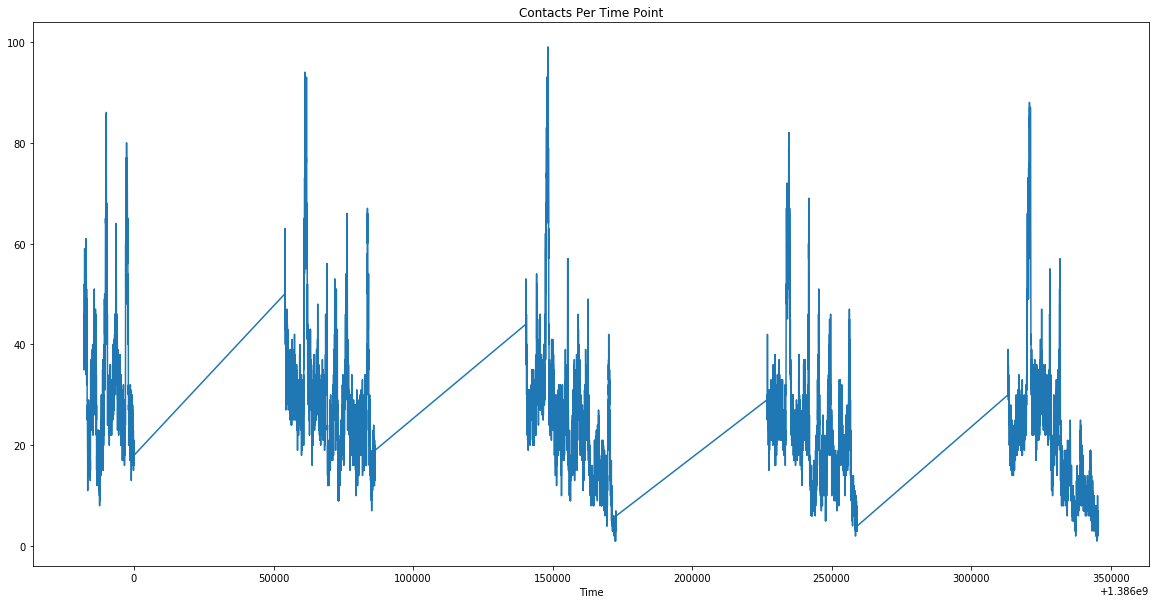

In [11]:
timed_contacts = timed_contacts.sort_values(['Time'])
timed_contacts.groupby('Time')['Student1'].count().plot(title="Contacts Per Time Point")

The time series data of the contact times have some seasonality. The 5 days the data was recorded are clearly seen. Peaks are probably the breaks between classes where students are free to talk to other students. I assume the peaks are weaker later during the recording because students might be less active during the later stages of the day due to exhaustion. There might as well be more classes during the morning.

In [12]:
count = facebook_pairs.is_friend.value_counts()
print(count)

fig = px.bar(x=facebook_pairs.is_friend.unique(), y=count, color=facebook_pairs.is_friend.unique(),labels={"sex": "Gender", "smoker": "Smokes"})
fig.show()

0    3078
1    1437
Name: is_friend, dtype: int64


In [152]:
G_d = nx.DiGraph()

for i in range(len(contact_diaries)):
    row = contact_diaries.loc[i,:]

    G_d.add_node(row.StudentID, Gender=row.Gender, Class=row.ClassID) 
    G_d.add_edge(row.StudentID, row.ReportedStudentID, weight=row.w)

G_d.nodes(data=True)

#This one is not mapped correctly
G_d.nodes[751]

{}

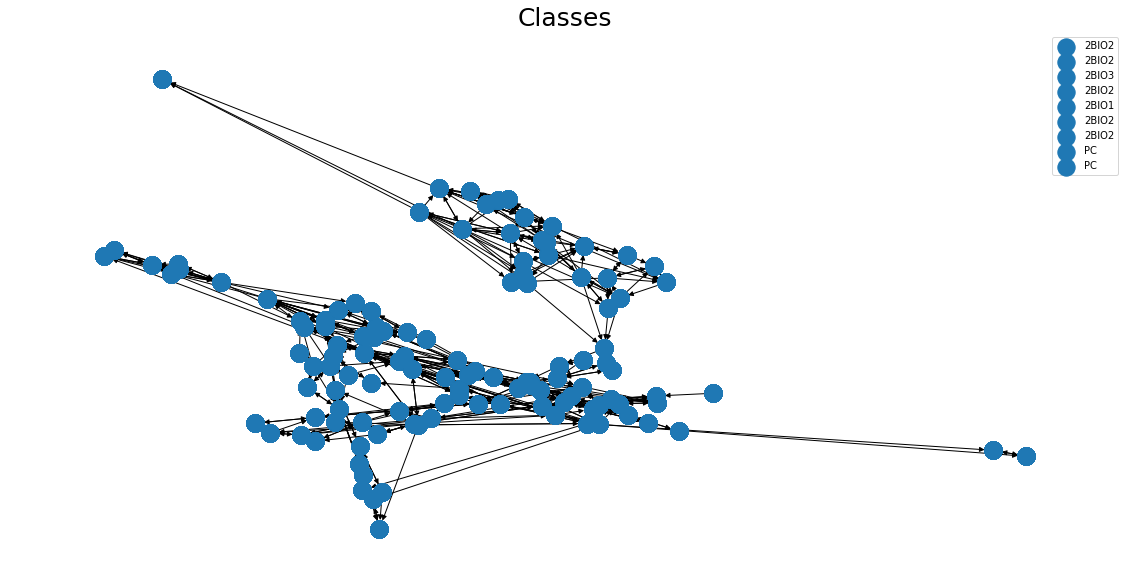

In [201]:
def random_color():
     return [random(), random(), random(), 1] 
    
pos = nx.drawing.layout.spring_layout(G_d, weight = 'Class', seed = 42)

i = 0;
for (nodeID, members) in G_d.nodes().items():
    #node_color = len(members) * [random_color[i]]
    i = i + 1
    
    #add weights if not instantiated correctly
    if(members == {}):
        G_d.nodes[nodeID]["Class"] = metadata[metadata.StudentID == nodeID].ClassID.item()
        G_d.nodes[nodeID]["Gender"] = metadata[metadata.StudentID == nodeID].Gender.item()    
        
    nx.draw_networkx_nodes(G_d, pos, label=members["Class"] if i < 10 else "")                                                                                                        

nx.draw_networkx_edges(G_d, pos)

#set title, legend and show plot
plt.title('Classes', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

In [209]:
for e in G_d.edges():
    print("Sample weight: ", G_diaries[e[0]][e[1]])
    break

print("info: ", nx.info(G_diaries))

Sample weight:  {'w': 2}
info:  Name: 
Type: DiGraph
Number of nodes: 120
Number of edges: 502
Average in degree:   4.1833
Average out degree:   4.1833


As shown above, the data set contains 120 nodes, 502 edges and 4.1833 average in/out degree.

### Trying to draw the different classes

In [197]:

from matplotlib.colors import ListedColormap
colors = ["pink", "red", "violet", "blue", 
          "turquoise", "limegreen", "gold", "brown"]  # use hex colors here, if desired.
cmap = ListedColormap(colors)

print(metadata.ClassID.unique())

def return_color(s):
    if s == "MP":
        return "skyblue"
    elif s == "MP*1":
        return "blue"
    elif s == "MP*2":
        return "darkblue"
    elif s == "PSI*":
        return "orchid"
    elif s == "PC":
        return "palevioletred"
    elif s == "PC*":
        return "dakslategrey"
    elif s == "2BIO1":
        return "lime"
    elif s == "2BIO2":
        return "forestgreen"
    elif s == "2BIO3":
        return "darkgreen"

colors = [return_color(i[1]["Class"]) for i in G_d.nodes().items()]
labels = [i[1]["Class"] for i in G_d.nodes().items()]

['2BIO1' '2BIO2' '2BIO3' 'MP*1' 'MP*2' 'PSI*' 'PC' 'PC*' 'MP']


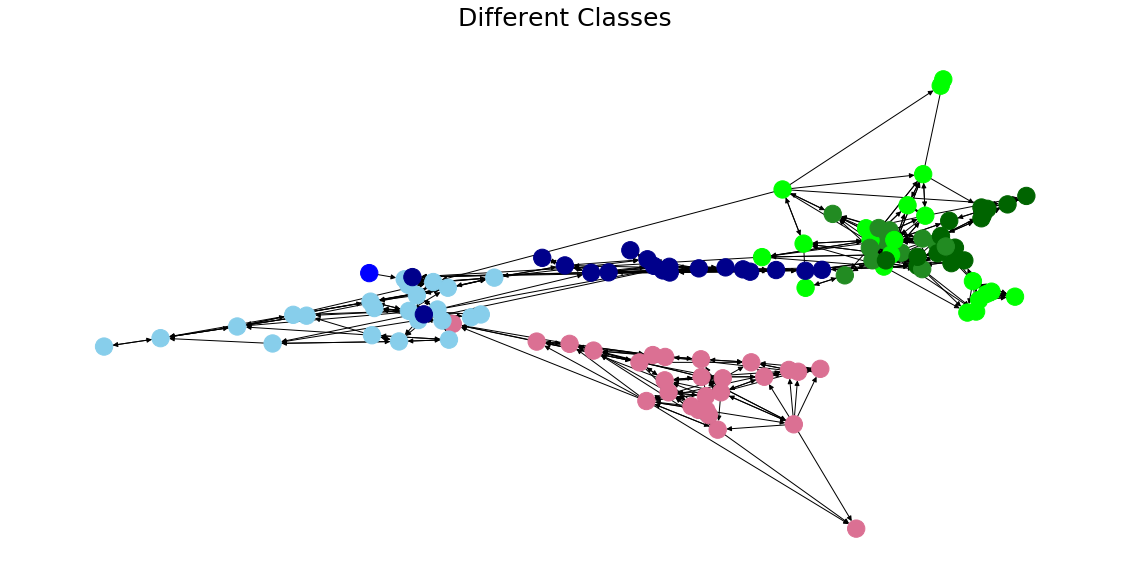

In [208]:
nx.draw_networkx(G_d, with_labels=False, node_color = colors, label=labels)
#set title, legend and show plot
plt.title('Different Classes', fontdict={'fontsize': 25})
#plt.legend() too many labels 
plt.axis('off')
plt.show()

This didn't work as the class labels were printed out multiple time in the matplot legend so I copied the approach of the course material.

In [210]:
from collections import defaultdict
people_per_class = defaultdict(list)
for (id, attributes) in list(G_d.nodes().data()):
    people_per_class[attributes["Class"]].append(id)
    
print(people_per_class)

defaultdict(<class 'list'>, {'2BIO2': [3, 28, 147, 295, 407, 327, 441, 478, 165, 268, 173, 429, 504, 372], '2BIO3': [106, 101, 119, 240, 364, 425, 272, 587, 122, 170, 494, 778, 255, 275, 265], '2BIO1': [177, 62, 650, 65, 681, 809, 124, 471, 475, 970, 145, 400, 428, 489, 945, 498, 857, 954, 984, 927, 725], 'PC': [15, 21, 48, 200, 211, 242, 480, 771, 791, 826, 845, 45, 79, 134, 232, 601, 488, 87, 388, 496, 89, 120, 285, 448, 751, 210, 468], 'MP*1': [20], 'MP': [634, 151, 156, 502, 694, 753, 866, 454, 159, 201, 640, 642, 245, 582, 691, 869, 874, 687, 520, 576, 605, 525, 577], 'MP*2': [1214, 1359, 1237, 1423, 1805, 1332, 1401, 1201, 1295, 1342, 1594, 1828, 1204, 1228, 1485, 1260, 1238, 1345, 1412]})


In [218]:
people_from_2Bio2 = {k: v for (k,v) in list(people_per_class.items()) if "2BIO2" in k}
print(people_from_2Bio2)

people_from_2Bio2_ids = set()
for (k, v) in people_from_2Bio2.items():
    people_from_2Bio2_ids.update(v)

print(people_from_2Bio2_ids)

G_2Bio2 = nx.subgraph(G_d, people_from_2Bio2_ids)
print("First class graph")
print(nx.info(G_2Bio2))

{'2BIO2': [3, 28, 147, 295, 407, 327, 441, 478, 165, 268, 173, 429, 504, 372]}
{3, 165, 295, 327, 268, 173, 429, 147, 372, 407, 504, 441, 28, 478}
First class graph
Name: 
Type: DiGraph
Number of nodes: 14
Number of edges: 53
Average in degree:   3.7857
Average out degree:   3.7857


The reports contain information about 14 individuals from class 2BIO2

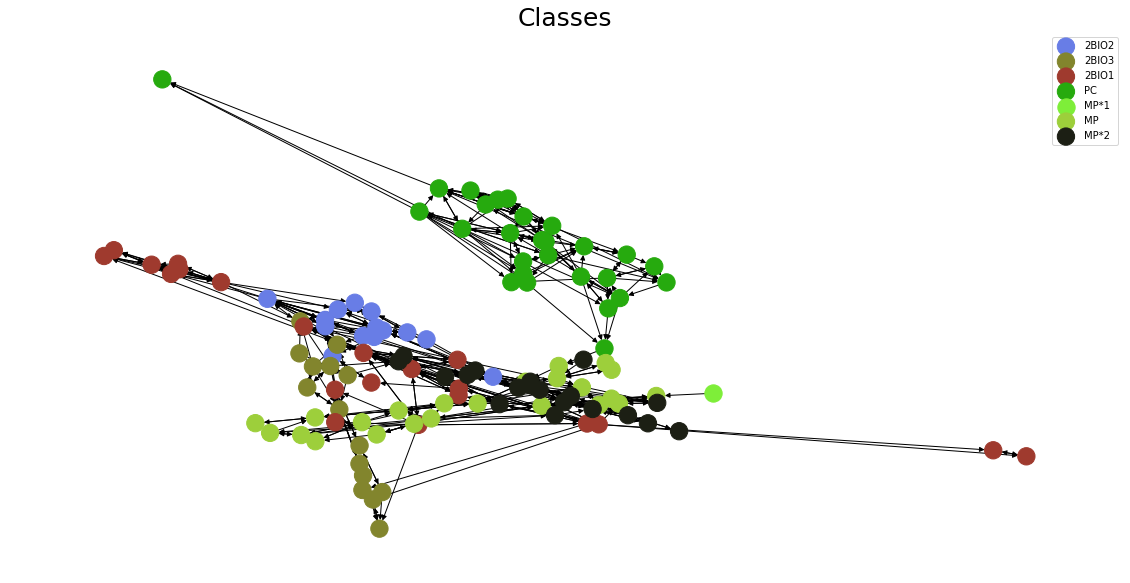

In [223]:
def random_color():
     return [random(), random(), random(), 1] 

random_colors = [random_color() for _ in range(len(list(people_per_class.keys())))]
pos = nx.drawing.layout.spring_layout(G_d, weight = 'w', seed = 42)

i = 0;
for (schoolclass, members) in people_per_class.items():
    node_color = len(members) * [random_colors[i]]
    i = i + 1
    nx.draw_networkx_nodes(G_d, pos, nodelist=members, node_color=node_color, label = schoolclass)                                                                                                        

nx.draw_networkx_edges(G_d, pos)

#set title, legend and show plot
plt.title('Classes', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

- Animation mit der Zeit

C:\Users\bruno\anaconda3\lib\site-packages\matplotlib\animation.py:973: UserWarning:

Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.



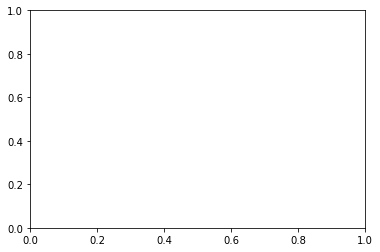

In [8]:
idx_colors = sns.cubehelix_palette(5, start=.5, rot=-.75)[::-1]
idx_weights = [3,2,1]

# Build plot
fig, ax = plt.subplots(figsize=(6,4))


def update(num):
    ax.clear()
    i = num // 3
    j = num % 3 + 1
    triad = sequence_of_letters[i:i+3]
    path = ["O"] + ["".join(sorted(set(triad[:k + 1]))) for k in range(j)]

    # Background nodes
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=set(G.nodes()) - set(path), node_color="white",  ax=ax)
    null_nodes.set_edgecolor("black")

    # Query nodes
    query_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=path, node_color=idx_colors[:len(path)], ax=ax)
    query_nodes.set_edgecolor("white")
    nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path,path)),  font_color="white", ax=ax)
    edgelist = [path[k:k+2] for k in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos=pos, edgelist=edgelist, width=idx_weights[:len(path)], ax=ax)

    # Scale plot ax
    ax.set_title("Frame %d:    "%(num+1) +  " - ".join(path), fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


ani = matplotlib.animation.FuncAnimation(fig, update, frames=6, interval=1000, repeat=True)
plt.show()